In [3]:
!pip install arch
!pip install alpaca-py
!pip install python-dotenv
!pip install ta
!pip install tensorflow
!pip install shap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 985.3/985.3 kB 36.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.7/121.7 kB 8.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ta: filename=ta-0.11.0-py3-none-any.whl size=29412 sha256=799b2dc40de0647bd9dbf7d31f69e0ab4fb5eff630e0bb7c409d6f551f097d36
  Stored in directory: /root/.cache/pip/wheels/a1/d7/29/7781cc5eb9a3659d032d7d15bdd0f49d07d2b24fec29f44bc4
Successfully built ta


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import plotly.graph_objects as go
import shap
import ta
import tensorflow as tf
from arch import arch_model
from datetime import datetime
from dotenv import load_dotenv
from statsmodels.stats.diagnostic import acorr_ljungbox
from alpaca.data.historical import CryptoHistoricalDataClient
from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, MultiHeadAttention, Layer, Lambda
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam

In [6]:
# Load environment variables from .env file
load_dotenv()

# Initialize the Alpaca CryptoHistoricalDataClient with credentials
client = CryptoHistoricalDataClient(
    api_key=os.getenv("APCA_API_KEY_ID"),
    secret_key=os.getenv("APCA_API_SECRET_KEY")
)

# Define the start and end dates for the data retrieval
start_date = datetime(2021, 1, 1)
end_date = datetime.now()

# Create a CryptoBarsRequest for BTC/USDT and ETH/USDT
request_params = CryptoBarsRequest(
    symbol_or_symbols=["BTC/USDT", "ETH/USDT"],
    timeframe=TimeFrame.Day,
    start=start_date,
    end=end_date
)

# Retrieve the historical bar data
bars = client.get_crypto_bars(request_params)

# Convert the data to a pandas DataFrame and display it
df = bars.df
print(df.head())


                                        open      high       low     close  \
symbol   timestamp                                                           
BTC/USDT 2021-01-01 06:00:00+00:00  29202.77  29611.51  28649.46  29596.45   
         2021-01-02 06:00:00+00:00  29592.30  34187.48  29459.22  33739.29   
         2021-01-03 06:00:00+00:00  33790.49  34776.59  32300.00  32808.20   
         2021-01-04 06:00:00+00:00  32834.48  33392.99  27500.00  30416.25   
         2021-01-05 06:00:00+00:00  30481.36  35755.02  29937.69  34964.28   

                                         volume  trade_count          vwap  
symbol   timestamp                                                          
BTC/USDT 2021-01-01 06:00:00+00:00   275.555320      12027.0  29219.342240  
         2021-01-02 06:00:00+00:00   757.022383      25410.0  31804.509959  
         2021-01-03 06:00:00+00:00   694.494847      28315.0  33492.652622  
         2021-01-04 06:00:00+00:00  1090.516262      34993.0  31175.

In [7]:
df = bars.df.copy()

# Reset index
df = df.reset_index()
print("Columns after reset_index():", df.columns)

# Check if timestamp is in datetime
datetime_col = 'timestamp' if 'timestamp' in df.columns else 'index'
df = df.rename(columns={datetime_col: 'datetime'})

# Sort data
df = df.sort_values(by=['symbol', 'datetime'])

# Pivot to wide format (one column per symbol)
price_df = df.pivot(index='datetime', columns='symbol', values='close')

# Rename columns
price_df.columns = ['btc_close', 'eth_close']

# Drop rows with missing values
price_df.dropna(inplace=True)

# Calculate daily log returns
price_df['btc_return'] = np.log(price_df['btc_close'] / price_df['btc_close'].shift(1))
price_df['eth_return'] = np.log(price_df['eth_close'] / price_df['eth_close'].shift(1))
price_df.dropna(inplace=True)

# Scale the closing prices
scaler = MinMaxScaler()
price_df[['btc_close_scaled', 'eth_close_scaled']] = scaler.fit_transform(
    price_df[['btc_close', 'eth_close']]
)

print("\nMerged & Preprocessed Data Sample:")
print(price_df.head())


Columns after reset_index(): Index(['symbol', 'timestamp', 'open', 'high', 'low', 'close', 'volume',
       'trade_count', 'vwap'],
      dtype='object')

Merged & Preprocessed Data Sample:
                           btc_close  eth_close  btc_return  eth_return  \
datetime                                                                  
2021-01-02 06:00:00+00:00   33739.29     785.65    0.131009    0.071045   
2021-01-03 06:00:00+00:00   32808.20    1087.20   -0.027985    0.324849   
2021-01-04 06:00:00+00:00   30416.25     989.10   -0.075701   -0.094565   
2021-01-05 06:00:00+00:00   34964.28    1101.17    0.139350    0.107333   
2021-01-06 06:00:00+00:00   37358.07    1210.23    0.066222    0.094437   

                           btc_close_scaled  eth_close_scaled  
datetime                                                       
2021-01-02 06:00:00+00:00          0.187484          0.000000  
2021-01-03 06:00:00+00:00          0.177750          0.074677  
2021-01-04 06:00:00+00:00   

In [8]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('BTC Closing Price Over Time', 'ETH Closing Price Over Time'))
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['btc_close'], mode='lines', name='BTC Close', line=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['eth_close'], mode='lines', name='ETH Close', line=dict(color='green')),
              row=2, col=1)
fig.update_layout(
    title='Daily Closing Prices Over Time',
    xaxis_title='Date',
    yaxis_title='Closing Price (USDT)',
    template='plotly',
    height=600  # Adjust height as needed
)

fig.update_yaxes(title_text='Closing Price (USDT)', row=1, col=1)
fig.update_yaxes(title_text='Closing Price (USDT)', row=2, col=1)
fig.show()

In [9]:
fig = make_subplots(rows=2, cols=1, subplot_titles=('BTC Log Return Over Time', 'ETH Log Return Over Time'))
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['btc_return'], mode='lines', name='BTC Log Return', line=dict(color='blue')),
              row=1, col=1)
fig.add_trace(go.Scatter(x=price_df.index, y=price_df['eth_return'], mode='lines', name='ETH Log Return', line=dict(color='green')),
              row=2, col=1)
fig.update_layout(
    title='Log Returns Over Time',
    xaxis_title='Date',
    yaxis_title='Log Return',
    template='plotly',
    height=600
)

fig.update_yaxes(title_text='Log Return', row=1, col=1)
fig.update_yaxes(title_text='Log Return', row=2, col=1)
fig.show()

In [10]:
# Train-test split
df = price_df.copy()
split_index = int(len(df) * 0.8)

train_df = df.iloc[:split_index]
test_df = df.iloc[split_index:]

print("Train Data Range:", train_df.index.min().date(), "to", train_df.index.max().date())
print("Test Data Range:", test_df.index.min().date(), "to", test_df.index.max().date())

Train Data Range: 2021-01-02 to 2024-06-16
Test Data Range: 2024-06-17 to 2025-06-09


In [11]:
train_df.head()

,btc_close,eth_close,btc_return,eth_return,btc_close_scaled,eth_close_scaled
datetime,,,,,,
2021-01-02 06:00:00+00:00,33739.29,785.65,0.131009,0.071045,0.187484,0.000000
2021-01-03 06:00:00+00:00,32808.20,1087.20,-0.027985,0.324849,0.177750,0.074677
2021-01-04 06:00:00+00:00,30416.25,989.10,-0.075701,-0.094565,0.152746,0.050383
2021-01-05 06:00:00+00:00,34964.28,1101.17,0.139350,0.107333,0.200289,0.078136
2021-01-06 06:00:00+00:00,37358.07,1210.23,0.066222,0.094437,0.225313,0.105144


##GARCH Model
GARCH model on BTC/USD Train and Test data


=== EGARCH(1,1) Model for BTC/USDT (Train Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             btc_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -3232.24
Distribution:                  Normal   AIC:                           6470.47
Method:            Maximum Likelihood   BIC:                           6485.90
                                        No. Observations:                 1262
Date:                Mon, Jun 09 2025   Df Residuals:                     1262
Time:                        14:47:36   Df Model:                            0
                               Volatility Model                              
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
ome

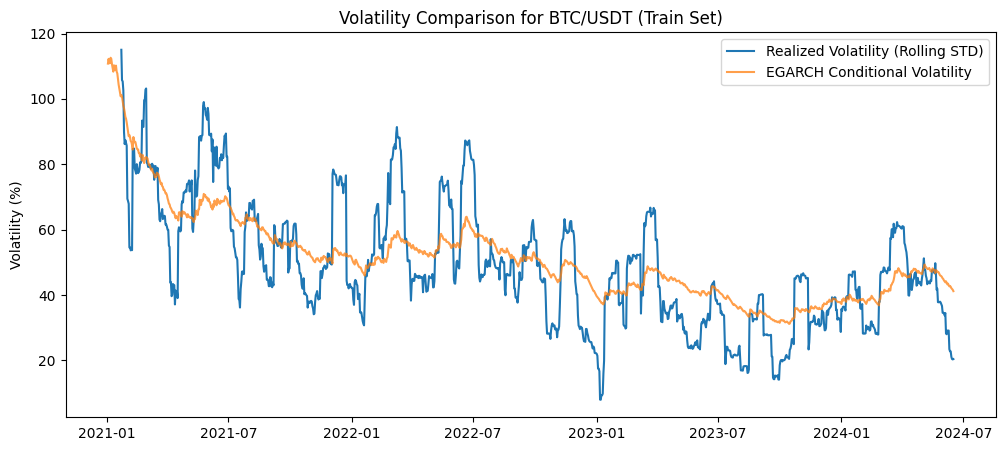

In [12]:
# Define a function to fit EGARCH and evaluate on given returns
def egarch_analysis(returns, symbol, rolling_window=21):
    print(f"\n=== EGARCH(1,1) Model for {symbol} ===")

    # Fit EGARCH(1,1) model to returns in percent (common scaling)
    am = arch_model(returns * 100, vol='EGARCH', p=1, q=1, dist='normal', mean='Zero')
    res = am.fit(update_freq=5, disp='off')
    print(res.summary())

    # Extract AIC and BIC
    print(f"AIC: {res.aic:.4f}, BIC: {res.bic:.4f}")

    # Ljung-Box test on squared standardized residuals (tests for ARCH effects)
    lb_test = acorr_ljungbox(res.std_resid ** 2, lags=[10], return_df=True)
    print("\nLjung-Box test for ARCH effects (p-value):")
    print(lb_test)

    # Calculate realized volatility (rolling std dev of returns scaled to annualized vol)
    realized_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252) * 100  # % annualized

    # EGARCH conditional volatility (annualized approx. because data is daily * 100)
    cond_vol = res.conditional_volatility * np.sqrt(252)  # annualized

    # Plot realized vs conditional volatility
    plt.figure(figsize=(12,5))
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (Rolling STD)')
    plt.plot(cond_vol.index, cond_vol, label='EGARCH Conditional Volatility', alpha=0.75)
    plt.title(f'Volatility Comparison for {symbol}')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

    return res

# Select train returns
btc_train_returns = train_df['btc_return'].dropna()
btc_res_train = egarch_analysis(btc_train_returns, 'BTC/USDT (Train Set)')


=== EGARCH(1,1) Model for BTC/USDT (Test Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             btc_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                     EGARCH   Log-Likelihood:               -743.736
Distribution:                  Normal   AIC:                           1493.47
Method:            Maximum Likelihood   BIC:                           1504.74
                                        No. Observations:                  316
Date:                Mon, Jun 09 2025   Df Residuals:                      316
Time:                        14:47:39   Df Model:                            0
                            Volatility Model                            
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
omega          0.31

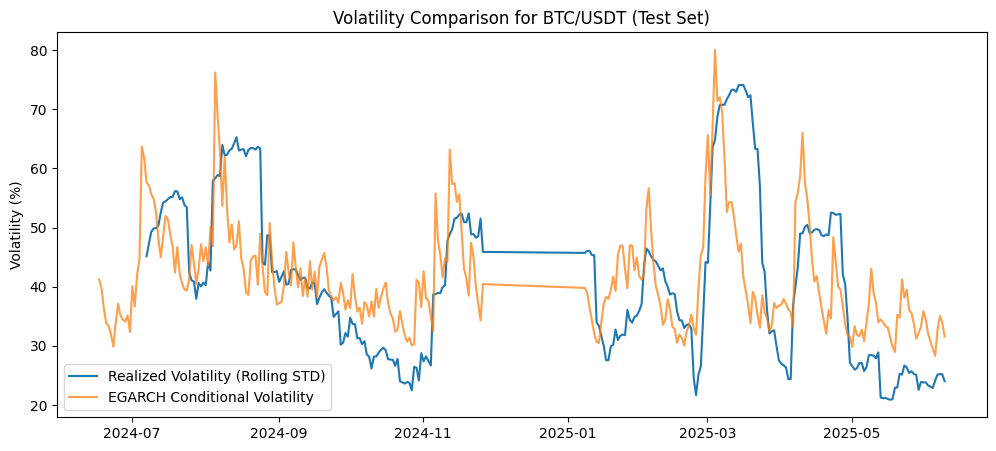

In [13]:
# Run EGARCH analysis on test data returns only
btc_test_returns = test_df['btc_return'].dropna()
btc_res_test = egarch_analysis(btc_test_returns, 'BTC/USDT (Test Set)')

GARCH model on ETH/USD Train and Test data


=== EGARCH(1,1) Model for ETH/USD (Train Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             eth_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.001
Vol Model:                     EGARCH   Log-Likelihood:               -3462.45
Distribution:                  Normal   AIC:                           6930.90
Method:            Maximum Likelihood   BIC:                           6946.32
                                        No. Observations:                 1262
Date:                Mon, Jun 09 2025   Df Residuals:                     1262
Time:                        14:47:42   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega     

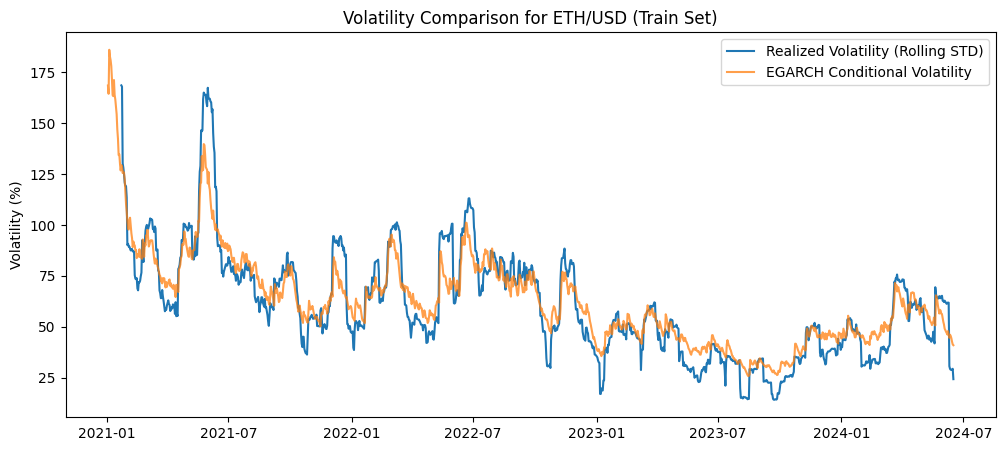

In [14]:
# Define a function to fit EGARCH and evaluate
def egarch_analysis(returns, symbol, rolling_window=21):
    print(f"\n=== EGARCH(1,1) Model for {symbol} ===")

    # Fit EGARCH(1,1) model to returns in percent (common scaling)
    am = arch_model(returns * 100, vol='EGARCH', p=1, q=1, dist='normal', mean='Zero')
    res = am.fit(update_freq=5, disp='off')
    print(res.summary())

    # Extract AIC and BIC
    print(f"AIC: {res.aic:.4f}, BIC: {res.bic:.4f}")

    # Ljung-Box test on squared standardized residuals (tests for ARCH effects)
    lb_test = acorr_ljungbox(res.std_resid ** 2, lags=[10], return_df=True)
    print("\nLjung-Box test for ARCH effects (p-value):")
    print(lb_test)

    # Calculate realized volatility (rolling std dev of returns scaled to annualized vol)
    realized_vol = returns.rolling(window=rolling_window).std() * np.sqrt(252) * 100  # % annualized

    # EGARCH conditional volatility (already annualized approx. because data is daily * 100)
    cond_vol = res.conditional_volatility * np.sqrt(252)  # annualized

    # Plot realized vs conditional volatility
    plt.figure(figsize=(12,5))
    plt.plot(realized_vol.index, realized_vol, label='Realized Volatility (Rolling STD)')
    plt.plot(cond_vol.index, cond_vol, label='EGARCH Conditional Volatility', alpha=0.75)
    plt.title(f'Volatility Comparison for {symbol}')
    plt.ylabel('Volatility (%)')
    plt.legend()
    plt.show()

    return res

eth_train_returns = train_df['eth_return'].dropna()
eth_res_train = egarch_analysis(eth_train_returns, 'ETH/USD (Train Set)')


=== EGARCH(1,1) Model for ETH/USD (Test Set) ===
                       Zero Mean - EGARCH Model Results                       
Dep. Variable:             eth_return   R-squared:                       0.000
Mean Model:                 Zero Mean   Adj. R-squared:                  0.003
Vol Model:                     EGARCH   Log-Likelihood:               -877.846
Distribution:                  Normal   AIC:                           1761.69
Method:            Maximum Likelihood   BIC:                           1772.96
                                        No. Observations:                  316
Date:                Mon, Jun 09 2025   Df Residuals:                      316
Time:                        14:47:44   Df Model:                            0
                              Volatility Model                             
                 coef    std err          t      P>|t|     95.0% Conf. Int.
---------------------------------------------------------------------------
omega      

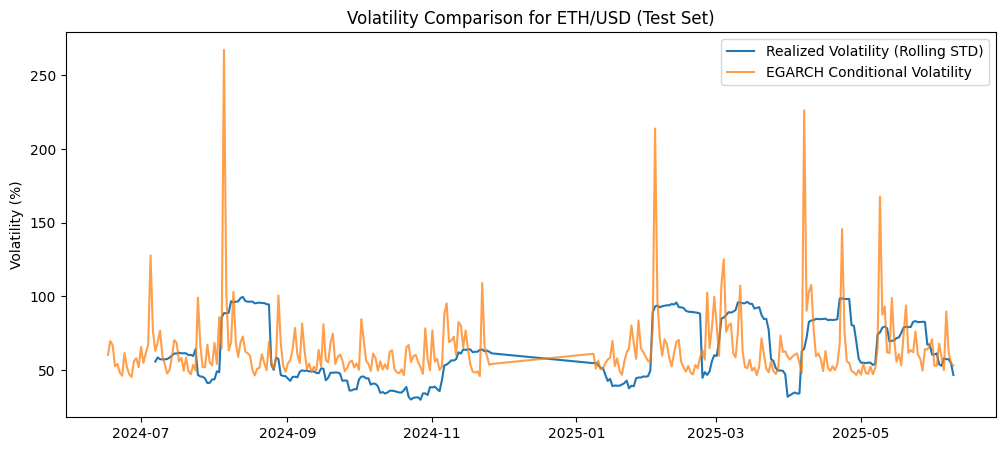

In [15]:
# Run EGARCH on ETH returns (Test Set)
eth_test_returns = test_df['eth_return'].dropna()
eth_res_test = egarch_analysis(eth_test_returns, 'ETH/USD (Test Set)')

##LSTM with Attention Mechanism


In [16]:
# Compute Spread
price_df['spread'] = price_df['eth_close_scaled'] - price_df['btc_close_scaled']

# Apply EGARCH volatility forecasts
price_df['btc_vol'] = np.nan
price_df['eth_vol'] = np.nan
price_df.loc[btc_res_train.conditional_volatility.index, 'btc_vol'] = btc_res_train.conditional_volatility / 100
price_df.loc[eth_res_train.conditional_volatility.index, 'eth_vol'] = eth_res_train.conditional_volatility / 100
price_df.dropna(subset=['spread', 'btc_vol', 'eth_vol'], inplace=True)

In [17]:
# Create Sequence
def create_sequences(df, seq_len=30):
    X, y_signal, y_vol = [], [], []
    for i in range(len(df) - seq_len):
        window = df[['spread','btc_vol','eth_vol']].iloc[i:i+seq_len].values
        fut = df['spread'].iloc[i+seq_len]
        mu, sigma = df['spread'].iloc[i:i+seq_len].mean(), df['spread'].iloc[i:i+seq_len].std()
        # classification target
        if fut < mu + sigma:
            sig = [1,0,0]
        elif fut > mu - sigma:
            sig = [0,1,0]
        else:
            sig = [0,0,1]
        X.append(window)
        y_signal.append(sig)
        y_vol.append(fut)
    return np.array(X), np.array(y_signal), np.array(y_vol)

seq_len = 30
X, y_signal, y_vol = create_sequences(price_df, seq_len)

# train-test split
train_size = int(len(X)*0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y_signal[:train_size], y_signal[train_size:]
vol_train, vol_test = y_vol[:train_size], y_vol[train_size:]

In [18]:
# LSTM with Attention Model
def build_lstm_attention_model(seq_len, n_features, n_heads=4):
    inp = Input((seq_len, n_features))
    x = tf.keras.layers.Bidirectional(LSTM(128, return_sequences=True))(inp)
    x = Dropout(0.2)(x)
    attn = MultiHeadAttention(num_heads=n_heads, key_dim=64)(x, x)
    x = tf.keras.layers.LayerNormalization()(x + attn)
    # temporal attention
    scores = Dense(1, activation='tanh')(x)
    weights = tf.keras.layers.Softmax(axis=1)(scores)
    context = Lambda(lambda t: tf.reduce_sum(t[0]*t[1], axis=1))([x, weights])
    # outputs
    signal_out = Dense(3, activation='softmax', name='signal')(context)
    vol_out = Dense(1, activation='linear', name='vol')(context)
    model = Model(inp, [signal_out, vol_out])
    model.compile(
        optimizer=Adam(1e-3),
        loss={'signal': 'categorical_crossentropy', 'vol': 'mse'},
        metrics={'signal': 'accuracy', 'vol': 'mse'}
    )
    return model

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 30, 3)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_1     │ (None, 30, 256)   │    135,168 │ input_layer_1[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 30, 256)   │          0 │ bidirectional_1[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 30, 256)   │    263,168 │ dropout_2[0][0],  │
│ (MultiHeadAttentio… │                   │            │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 30, 256)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 30, 256)   │        512 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 30, 1)     │        257 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ softmax_3 (Softmax) │ (None, 30, 1)     │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_1 (Lambda)   │ (None, 256)       │          0 │ layer_normalizat… │
│                     │                   │            │ softmax_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ signal (Dense)      │ (None, 3)         │        771 │ lambda_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vol (Dense)         │ (None, 1)         │        257 │ lambda_1[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 400,133 (1.53 MB)

 Trainable params: 400,133 (1.53 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 13s 182ms/step - loss: 1.3344 - signal_accuracy: 0.7149 - signal_loss: 0.6589 - vol_loss: 0.6754 - vol_mse: 0.6756 - val_loss: 0.5970 - val_signal_accuracy: 0.7368 - val_signal_loss: 0.5734 - val_vol_loss: 0.0278 - val_vol_mse: 0.0281
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 151ms/step - loss: 0.5516 - signal_accuracy: 0.7553 - signal_loss: 0.5348 - vol_loss: 0.0168 - vol_mse: 0.0168 - val_loss: 0.5595 - val_signal_accuracy: 0.7368 - val_signal_loss: 0.5603 - val_vol_loss: 0.0030 - val_vol_mse: 0.0030
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 6s 188ms/step - loss: 0.5126 - signal_accuracy: 0.7851 - signal_loss: 0.5071 - vol_loss: 0.0055 - vol_mse: 0.0055 - val_loss: 0.5357 - val_signal_accuracy: 0.7368 - val_signal_loss: 0.5381 - val_vol_loss: 0.0024 - val_vol_mse: 0.0023
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 153ms/step - loss: 0.5007 - signal_accuracy: 0.7760 - signal_loss: 0.4950 - vol_loss: 0.0056 - vol_mse: 0.0056 - val_loss: 0.4921 - val_signal

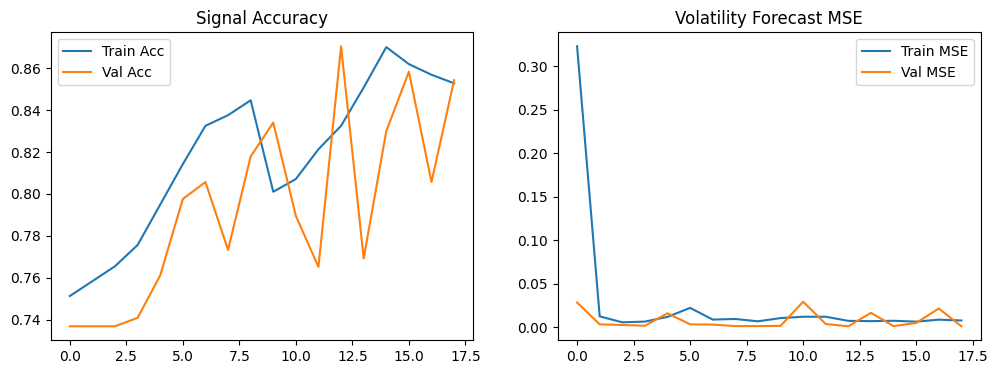

In [20]:
# Build and Train Model
model = build_lstm_attention_model(seq_len, n_features=3)
model.summary()

# Callbacks
ess = tf.keras.callbacks.EarlyStopping(monitor='val_signal_accuracy', patience=5, mode='max', restore_best_weights=True)

history = model.fit(
    X_train, {'signal': y_train, 'vol': vol_train},
    validation_data=(X_test, {'signal': y_test, 'vol': vol_test}),
    epochs=50,
    batch_size=32,
    callbacks=[ess]
)

# Plot Training History
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(history.history['signal_accuracy'], label='Train Acc')
plt.plot(history.history['val_signal_accuracy'], label='Val Acc')
plt.title('Signal Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['vol_mse'], label='Train MSE')
plt.plot(history.history['val_vol_mse'], label='Val MSE')
plt.title('Volatility Forecast MSE')
plt.legend()
plt.show()


##Backtesting


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 436ms/step
Total Return: 125.09%
Sharpe Ratio: 1.14
Maximum Drawdown: -23.03%


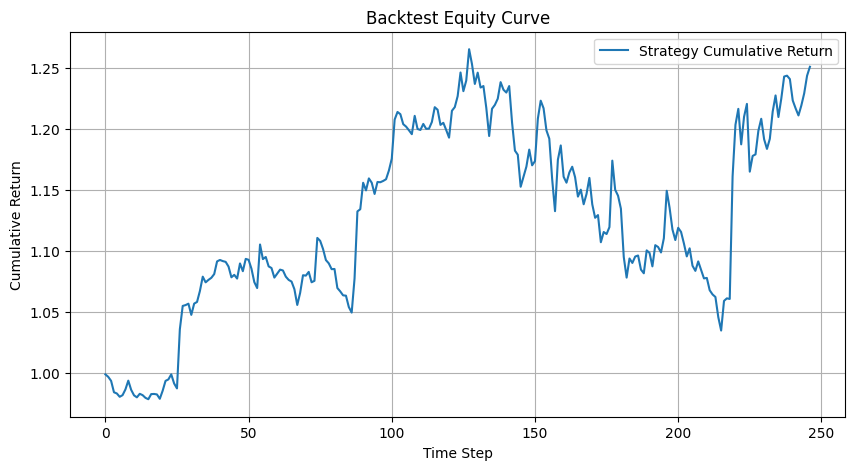

In [21]:
# Predict with LSTM
y_pred_probs, y_vol_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred_probs, axis=1)

signal_map = {0: 1, 1: -1, 2: 0}
predicted_signals = np.array([signal_map[c] for c in y_pred_class])

# Compute Returns
spread_test = y_vol[train_size:]
spread_returns = np.diff(spread_test, prepend=spread_test[0])
strategy_returns = predicted_signals * spread_returns

transaction_cost = 0.001
signal_change = np.abs(np.diff(predicted_signals, prepend=0))
costs = signal_change * transaction_cost
net_returns = strategy_returns - costs
cumulative_returns = np.cumprod(1 + net_returns)

# Performance
total_return = cumulative_returns[-1]
sharpe_ratio = np.mean(net_returns) / np.std(net_returns) * np.sqrt(252)
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")

# Performance Plot
plt.figure(figsize=(10,5))
plt.plot(cumulative_returns, label='Strategy Cumulative Return')
plt.title('Backtest Equity Curve')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()


##Backtesting with Altcoin Season Index filter


Total Return: 156.71%
Sharpe Ratio: 3.01
Maximum Drawdown: -4.02%


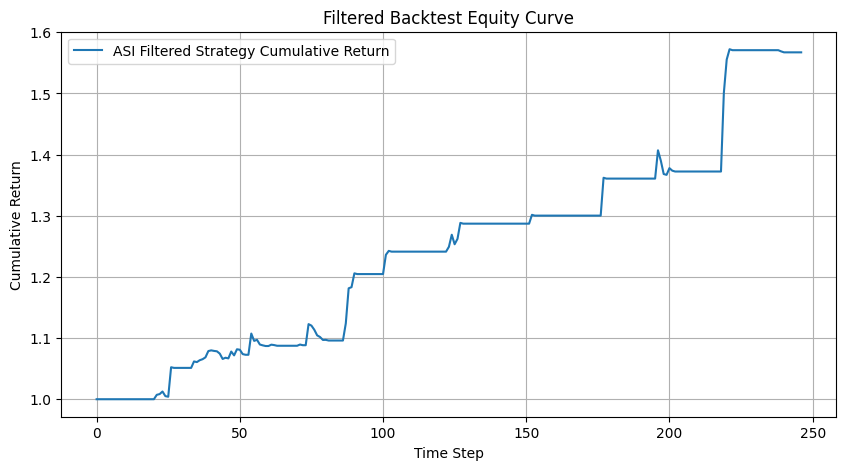

In [22]:
# Compute Altcoin Season Index Filter
window = 30  # Lookback window for altcoin season detection
price_df['eth_btc_ma'] = price_df['spread'].rolling(window=window, min_periods=1).mean()
price_df['altcoin_season'] = (price_df['spread'] > price_df['eth_btc_ma']).astype(int)

# Apply Altcoin Season Filter
altcoin_season_test = price_df['altcoin_season'].values[train_size + seq_len : train_size + seq_len + len(X_test)]

filtered_signals = np.where(
    altcoin_season_test == 1,  # In altcoin season
    np.where(predicted_signals == 1, 1, 0),  # Only allow long positions
    np.where(predicted_signals == -1, -1, 0)  # Only allow short positions
)

# Compute Returns
spread_test = y_vol[train_size:]
spread_returns = np.diff(spread_test, prepend=spread_test[0])
strategy_returns = filtered_signals * spread_returns

transaction_cost = 0.001
signal_change = np.abs(np.diff(filtered_signals, prepend=0))
costs = signal_change * transaction_cost
net_returns = strategy_returns - costs
cumulative_returns = np.cumprod(1 + net_returns)

# Performance
total_return = cumulative_returns[-1]
sharpe_ratio = np.mean(net_returns) / np.std(net_returns) * np.sqrt(252)
max_drawdown = np.min(cumulative_returns - np.maximum.accumulate(cumulative_returns))

print(f"Total Return: {total_return*100:.2f}%")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")
print(f"Maximum Drawdown: {max_drawdown*100:.2f}%")

# Performance Plot
plt.figure(figsize=(10,5))
plt.plot(cumulative_returns, label='ASI Filtered Strategy Cumulative Return')
plt.title('Filtered Backtest Equity Curve')
plt.xlabel('Time Step')
plt.ylabel('Cumulative Return')
plt.legend()
plt.grid(True)
plt.show()